In [3]:
from huggingface_hub import login
login()

In [8]:
!pip install -q bitsandbytes datasets accelerate loralib
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git

In [1]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

peft_model_id = "harshasurampudi/gptj-lfqa-with-reasoning"
config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, return_dict=True, load_in_8bit=True)
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6b")
tokenizer.padding_side="left"

# Load the Lora model
model = PeftModel.from_pretrained(model, peft_model_id)

In [11]:
from transformers import GenerationConfig, pipeline
config = GenerationConfig(
    do_sample=True,
    max_new_tokens=350,
    top_p=1,
    pad_token_id = tokenizer.eos_token_id)

In [12]:
import pandas as pd

df = pd.read_csv('test_extracted.csv')
df

,Context,Question,Legal Reasoning,Answer
0,and Statistical Manual of Mental Disorders 446...,Can the defendants force Dr. Nadel to provide ...,The issue at hand pertains to the compulsion o...,"No, according to the Graham v. Gielchinsky cas..."
1,"one of his trial counsel as a witness, so the ...",Did the Appellee's trial counsel have knowledg...,The question at hand pertains to the knowledge...,It is uncertain whether the Appellee's trial c...
2,Some of Cruikshank’s objections on appeal appe...,Can Cruikshank's objections on the trial court...,The issue at hand pertains to the admissibilit...,"No, Cruikshank's objections on the trial court..."
3,noting that the additional materials provided ...,Can the motion to strike filed by PFM be consi...,The question pertains to the categorization of...,"Yes, the motion to strike filed by PFM can be ..."
4,The State is within the powers reserved to it ...,Can the State refuse to enter into agreements ...,The question revolves around the State's power...,"Yes, the State has the power to refuse to ente..."
...,...,...,...,...
1492,The new biological opinion included an inciden...,Is the Consent Decree considered an injunction...,The question revolves around whether the Conse...,The classification of the Consent Decree as an...
1493,(a) Appealable Orders. (1) The following order...,"Can a party appeal a disposition, review, no r...",The question pertains to the appealability of ...,"Yes, a party can appeal a disposition, review,..."
1494,"criminal laws.” Spaziano v. Florida, 468 U.S. ...",Can the sentence imposed on Williams be consid...,The question pertains to the constitutionality...,"No, the sentence imposed on Williams is not un..."
1495,"F.Supp.3d 700, 703, No. 3:14CV200 (JMM), 2014 ...",Can an entity be held liable for unsolicited c...,The question pertains to the liability of an e...,"Yes, an entity can be held liable for unsolici..."


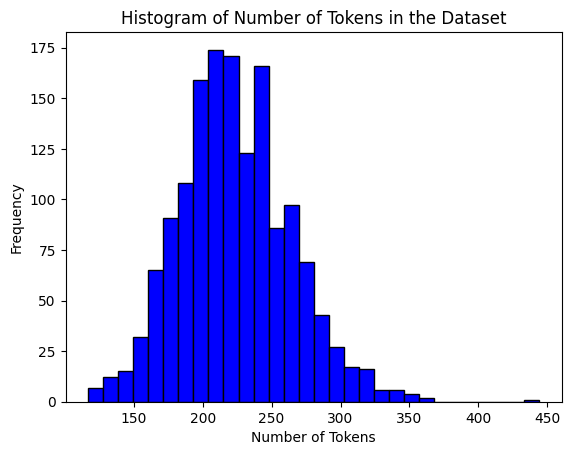

In [13]:
import matplotlib.pyplot as plt
# Generate the expected strings and tokenize them
expected_strings = df.apply(lambda row: f"""
{row['Legal Reasoning']}
Answer:
{row['Answer']}""", axis=1)
token_counts = [len(tokenizer.encode(s)) for s in expected_strings]

# Plot the histogram
plt.hist(token_counts, bins=30, color='blue', edgecolor='black')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Tokens in the Dataset')
plt.show()

In [14]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    batch_size=16,
    generation_config=config,
)
pipe.tokenizer.pad_token_id = model.config.eos_token_id

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead',

In [10]:
inp_text ="""Context:
Stat. § 14-32.1(a), does not make the definition an essential element of the crime pursuant to N.C. Gen. Stat. § 14-32.1(e). Therefore, we reject Defendant’s argument that it is not sufficient for the indictment to “merely state that the victim was ‘handicapped.’ ” Furthermore, the indictment provided Defendant with enough information to prepare a defense for the offense of felony assault on a handicapped person. See Leonard, _ N.C. App. at _, 711 S.E.2d at 873 (rejecting the defendant’s argument that the indictment was not sufficient because the indictment tracked the relevant language of the statute, listed “the essential elements of the offense[,]” and provided the defendant “with enough information to prepare a defense”); State v. Crisp, 126 N.C. App. 30, 36, 483 S.E.2d 462, 466 (<HOLDING>), appeal dismissed and disc. review denied, 346
Question: Is it necessary for the definition of the crime to be stated in the indictment according to N.C. Gen. Stat. § 14-32.1(a)?
Reasoning:
"""

pipe(inp_text)

[{'generated_text': 'Context:\nStat. § 14-32.1(a), does not make the definition an essential element of the crime pursuant to N.C. Gen. Stat. § 14-32.1(e). Therefore, we reject Defendant’s argument that it is not sufficient for the indictment to “merely state that the victim was ‘handicapped.’ ” Furthermore, the indictment provided Defendant with enough information to prepare a defense for the offense of felony assault on a handicapped person. See Leonard, _ N.C. App. at _, 711 S.E.2d at 873 (rejecting the defendant’s argument that the indictment was not sufficient because the indictment tracked the relevant language of the statute, listed “the essential elements of the offense[,]” and provided the defendant “with enough information to prepare a defense”); State v. Crisp, 126 N.C. App. 30, 36, 483 S.E.2d 462, 466 (<HOLDING>), appeal dismissed and disc. review denied, 346\nQuestion: Is it necessary for the definition of the crime to be stated in the indictment according to N.C. Gen. Sta

In [15]:
df['Prompt'] = df.apply(lambda row:f"""Context:
{row['Context']}
Question:
{row['Question']}
Reasoning:
""", axis=1)

prompts = df['Prompt'].to_list()

In [16]:
from datasets import Dataset
test_dataset = Dataset.from_pandas(df[['Prompt']])

In [17]:
test_dataset

Dataset({
    features: ['Prompt'],
    num_rows: 1497
})

In [20]:
i=0
from transformers.pipelines.pt_utils import KeyDataset
for out in pipe(KeyDataset(test_dataset, "Prompt")):
    df.loc[i, 'Generated Text'] = out[0]['generated_text']
    df.to_csv('test_generated.csv', index=False)
    i+=1
    print(i, end='\r')